In [2]:
import numpy as np
import networkx as nx
import random
from tqdm import tqdm
import itertools

In [3]:
# Fonction d'initialisation des phéromones
def initialize_pheromones(G):
    pheromones = {}
    for edge in G.edges():
        pheromones[edge] = 1.0
        pheromones[(edge[1], edge[0])] = 1.0  # Assurer la symétrie
    return pheromones

In [4]:
# Fonction pour calculer la probabilité de transition
def calculate_transition_probabilities(G, pheromones, alpha, beta, current_node, visited):
    probabilities = {}
    total_sum = 0.0
    for neighbor in G.neighbors(current_node):
        if neighbor not in visited:
            distance = G[current_node][neighbor]['weight']
            probabilities[neighbor] = (pheromones[(current_node, neighbor)] ** alpha) * \
                                      ((1.0 / distance) ** beta)
            total_sum += probabilities[neighbor]
    
    if total_sum == 0:
        return None

    for neighbor in probabilities:
        probabilities[neighbor] /= total_sum
    
    return probabilities

In [5]:
# Fonction pour trouver un chemin pour une fourmi
def find_path(G, pheromones, alpha, beta, start_node):
    path = [start_node]
    visited = set(path)
    current_node = start_node
    while len(visited) < len(G.nodes()):
        probabilities = calculate_transition_probabilities(G, pheromones, alpha, beta, current_node, visited)
        if probabilities is None:
            return None
        next_node = random.choices(list(probabilities.keys()), weights=list(probabilities.values()))[0]
        path.append(next_node)
        visited.add(next_node)
        current_node = next_node
    path.append(start_node)  # Retourner au point de départ
    return path

In [6]:
# Fonction pour mettre à jour les phéromones
def update_pheromones(G, pheromones, paths, decay):
    for edge in pheromones:
        pheromones[edge] *= (1 - decay)
    for path in paths:
        length = calculate_path_length(G, path)
        for i in range(len(path) - 1):
            from_node = path[i]
            to_node = path[i + 1]
            if (from_node, to_node) in pheromones:
                pheromones[(from_node, to_node)] += 1.0 / length
                pheromones[(to_node, from_node)] += 1.0 / length  # Assurer la symétrie

In [7]:
# Fonction pour calculer la longueur d'un chemin
def calculate_path_length(G, path):
    length = 0
    for i in range(len(path) - 1):
        from_node = path[i]
        to_node = path[i + 1]
        if G.has_edge(from_node, to_node):
            length += G[from_node][to_node]['weight']
        else:
            return float('inf')  # Retourner une longueur infinie si l'arête n'existe pas
    return length

In [26]:
# Fonction principale de l'algorithme
def ant_colony_optimization(G, num_ants, num_iterations, decay, alpha, beta, show_progress=True):
    pheromones = initialize_pheromones(G)
    best_path = None
    best_length = float('inf')
    
    # Sélectionnez la méthode d'itération en fonction du paramètre show_progress
    iterations = tqdm(range(num_iterations), desc="Iterations") if show_progress else range(num_iterations)
    
    for iteration in iterations:
        paths = []
        for _ in range(num_ants):
            start_node = random.choice(list(G.nodes()))
            path = find_path(G, pheromones, alpha, beta, start_node)
            if path is None:
                continue
            length = calculate_path_length(G, path)
            if length == float('inf'):
                continue
            paths.append(path)
            if length < best_length:
                best_length = length
                best_path = path
        update_pheromones(G, pheromones, paths, decay)
        # print(f"Iteration {iteration+1}/{num_iterations}, Best length: {best_length}")
    return best_path, best_length

In [27]:
def brute_force(G):
    nodes = list(G.nodes())
    min_path = None
    min_length = float('inf')
    permutations = list(itertools.permutations(nodes))
    for perm in tqdm(permutations, desc="Calcul naïf"):
        current_length = 0
        valid = True
        # Calculer la longueur du chemin pour cette permutation
        for i in range(len(perm) - 1):
            if G.has_edge(perm[i], perm[i + 1]):
                current_length += G[perm[i]][perm[i + 1]]['weight']
            else:
                valid = False
                break
        if valid and G.has_edge(perm[-1], perm[0]):
            current_length += G[perm[-1]][perm[0]]['weight']
        else:
            valid = False
        # Mettre à jour le chemin minimal si un chemin valide plus court est trouvé
        if valid and current_length < min_length:
            min_length = current_length
            min_path = perm
    if min_path is not None:
        min_path = list(min_path)
        min_path.append(min_path[0])  # Retour au point de départ
    return min_path, min_length

In [28]:
def ant_colony_optimization_viz(G, num_ants, num_iterations, decay, alpha, beta, show_progress=True):
    pheromones = initialize_pheromones(G)
    best_path = None
    best_length = float('inf')
    lengths_per_iteration = []

    # Sélectionnez la méthode d'itération en fonction du paramètre show_progress
    iterations = tqdm(range(num_iterations), desc="Iterations") if show_progress else range(num_iterations)
    
    for iteration in iterations:
        paths = []
        for _ in range(num_ants):
            start_node = random.choice(list(G.nodes()))
            path = find_path(G, pheromones, alpha, beta, start_node)
            if path is None:
                continue
            length = calculate_path_length(G, path)
            if length == float('inf'):
                continue
            paths.append(path)
            if length < best_length:
                best_length = length
                best_path = path
        update_pheromones(G, pheromones, paths, decay)
        lengths_per_iteration.append(best_length)
        # print(f"Iteration {iteration+1}/{num_iterations}, Best length: {best_length}")
    
    return best_path, best_length, lengths_per_iteration

In [29]:
def plot_lengths_per_iteration(lengths):
    iterations = list(range(1, len(lengths) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, lengths, marker='o', linestyle='-', color='b')
    plt.xlabel('Numéro de l\'itération')
    plt.ylabel('Taille du chemin trouvé')
    plt.title('Évolution de la taille du chemin trouvé par itération')
    plt.grid(True)
    plt.show()

### Exemple d'utilisation

In [30]:
# Extrait du notebook Génération & Visualisation des graphes
# Fonction pour générer un graphe aléatoire
def random_graph(num_nodes):
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            weight = random.randint(1, 10)
            G.add_edge(i, j, weight=weight)
    return G

In [31]:
# Exemple d'execution
# Paramètres de l'algorithme
num_ants = 100
num_iterations = 50
decay = 0.5
alpha = 1
beta = 2
# Exemple d'utilisation avec un graphe networkx
# Générer un graphe aléatoire avec 10 nœuds
best_path, best_length = ant_colony_optimization(random_graph(10), num_ants, num_iterations, decay, alpha, beta,show_progress=False)
print(f"Meilleur chemin trouvé: {best_path} avec une longueur de: {best_length}")

Meilleur chemin trouvé: [4, 8, 3, 2, 6, 1, 5, 9, 7, 0, 4] avec une longueur de: 23


Iterations: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.06s/it]


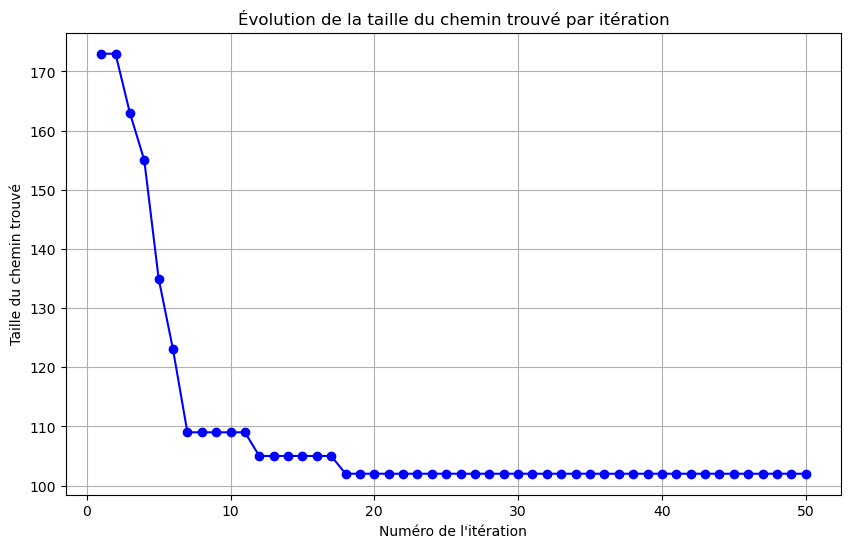

Meilleur chemin trouvé: [16, 98, 0, 22, 7, 69, 81, 90, 70, 78, 4, 12, 51, 43, 56, 28, 2, 75, 49, 34, 88, 27, 13, 93, 50, 11, 97, 24, 57, 5, 38, 35, 3, 94, 72, 79, 76, 87, 85, 73, 71, 61, 62, 45, 52, 64, 68, 9, 48, 53, 63, 67, 92, 8, 77, 59, 19, 32, 65, 10, 31, 89, 25, 36, 55, 17, 23, 41, 47, 91, 1, 15, 20, 74, 96, 82, 66, 40, 46, 80, 44, 33, 58, 86, 83, 99, 30, 18, 26, 37, 60, 54, 29, 42, 6, 95, 39, 84, 14, 21, 16] avec une longueur de: 102


In [32]:
# Exemple d'utilisation
G = random_graph(100)
best_path, best_length, lengths_per_iteration = ant_colony_optimization_viz(G, num_ants, num_iterations, decay, alpha, beta, show_progress=True)
plot_lengths_per_iteration(lengths_per_iteration)
print(f"Meilleur chemin trouvé: {best_path} avec une longueur de: {best_length}")
